# Terrestrial Laser Scanning of a Small Apple Tree with Leaf Flutter

Notebook: Hannah Weiser, 2023

This is a demonstration of scanning a [dynamic scene](https://github.com/3dgeo-heidelberg/helios/wiki/Dynamic-scenes), consisting of a tree with moving leaves.

We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.

In [1]:
import sys, os
from pathlib import Path
from IPython.display import Code

current_folder = globals()['_dh'][0]
helios_path = str(Path(current_folder).parent)
sys.path.append(helios_path)  # add helios-plusplus directory to PATH
import pyhelios

from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

os.chdir(helios_path)

## Scene

The scene was generated in [Blender](https://www.blender.org/) using three add-ons:
- [Sapling Tree Gen](https://docs.blender.org/manual/en/latest/addons/add_curve/sapling.html): This add-on allows to create trees using a set of parameters, using the algorithm by [Weber & Penn (1995)](https://doi.org/10.1145/218380.218427). For the resulting tree, the stem curve was converted to a mesh, and the leaves were separated "By Loose Parts" to obtain each leaf separately.
- [Move Leaves](https://github.com/han16nah/movingtree_b2h/blob/main/addons/moveleaves.py): This add-on creates a leaf animation for a given tree (created by e.g, Sapling Tree Gen) by rotating the leaves around their leaf base. The user can provide an initial leaf angle distribution, the (random) fraction of leaves moving, the oscillation frequency and the normal distributions $N$($\mu$, $\sigma$), from which the three Euler rotation angles x, y and z will be sampled at each time step.
- [DynScene2HELIOS](https://github.com/3dgeo-heidelberg/dyn_b2h): This add-on allows exporting dynamic Blender scenes (i.e., scenes with rigid motions) to HELIOS++ sceneparts and scenes. It considers translations and rotations.

Finally, further modifications were made:
- A wavefront material template library (MTL) was assigned, which contains `helios_spectra` and `helios_classification` for the different materials (leaf and wood) to assign realistic reflectance values and to create an automatic classification of the output point cloud.

The exported scene is very large, but you can have a look [here](https://github.com/3dgeo-heidelberg/helios/blob/dev/data/scenes/movingtrees/tree10_a.xml).

## Platform and Scanner

We are performing a terrestrial laser scanning (TLS) simulation from a static tripod with a RIEGL VZ-400. Platform and scanner are shown below:

In [2]:
Code(display_xml('data/platforms.xml', 'tripod'), language='XML')

<platform id="tripod" name="TLS Tripod" type="static" drag="0">
		<scannerMount x="0" y="0" z="1.5">
		</scannerMount>
	</platform>

In [3]:
Code(display_xml('data/scanners_tls.xml', 'riegl_vz400'), language='XML')

<scanner id="riegl_vz400" name="RIEGL VZ-400" accuracy_m="0.005" beamDivergence_rad="0.0003" headRotatePerSecMax_deg="60" optics="rotating" pulseFreqs_Hz="100000,300000" pulseLength_ns="5" rangeMin_m="1.5" scanAngleMax_deg="120" scanAngleEffectiveMax_deg="50" scanFreqMin_Hz="3" scanFreqMax_Hz="120">
		
		<FWFSettings beamSampleQuality="3" />	
		<beamOrigin x="0" y="0" z="0.2">
			<rot axis="y" angle_deg="0" />
			<rot axis="z" angle_deg="0" />
			<rot axis="x" angle_deg="0" />
		</beamOrigin>
		<headRotateAxis x="0" y="0" z="1" />
		
	</scanner>

## Survey

Six scan positions are created, regularly distributed on a circle around the tree. From each position, the scanner is pointing towards the tree and scans in a horizontal field of view of 90° and a vertical FOV of 100°. Vertical and horizontal resolution are set to 0.04 ° which corresponds to a point spacing of 7 mm at 10 m range.

In [4]:
Code(display_xml('data/surveys/movingtrees_tls/tls_tree1_a.xml'), language='XML')

<document>
        <scannerSettings id="tls" active="true" pulseFreq_hz="600000" verticalResolution_deg="0.04" horizontalResolution_deg="0.04" />
        <survey name="tls_tree1_a" platform="data/platforms.xml#tripod" scanner="data/scanners_tls.xml#riegl_vz400" scene="data/scenes/movingtrees/tree1_a.xml#tree1">
            <leg>
            <platformSettings x="3.0000" y="0.0000" z="0" onGround="true" />
            <scannerSettings template="tls" headRotateStart_deg="45.0000" headRotateStop_deg="135.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="1.5000" y="2.5981" z="0" onGround="true" />
            <scannerSettings template="tls" headRotateStart_deg="105.0000" headRotateStop_deg="195.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="-1.5000" y="2.5981" z="0" onGround="true" />
            <scannerSettings template="tls" headRotateStart_deg="-195.0000" headRotateStop_deg="-105.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="-3.0000" y="0.0000" z="0" onGround="true" />
            <scannerSettings template="tls" headRotateStart_deg="-135.0000" headRotateStop_deg="-45.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="-1.5000" y="-2.5981" z="0" onGround="true" />
            <scannerSettings template="tls" headRotateStart_deg="-75.0000" headRotateStop_deg="15.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="1.5000" y="-2.5981" z="0" onGround="true" />
            <scannerSettings template="tls" headRotateStart_deg="-15.0000" headRotateStop_deg="75.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        
        </survey>
    </document>

## Running the Simulation

Let's run the simulation. This will take considerably longer than for static scenes.


In [5]:
!"run/helios" data/surveys/movingtrees_tls/tls_tree10_a.xml "--lasOutput" "--zipOutput" "-q"

## Loading the Simulated Point Cloud

In [6]:
import numpy as np
import laspy
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
output_path = find_playback_dir('data/surveys/movingtrees_tls/tls_tree1_a.xml')

print('Loading points from', Path(output_path).relative_to(helios_path).as_posix())

def read_pc(path, pt_src_id):
    las = laspy.read(path)
    pc = np.array([las.x, las.y, las.z]).T
    object_id = las['hitObjectId']
    gps_time = las['gps_time']
    classification = las['classification']
    pt_src_id = np.repeat(pt_src_id, pc.shape[0])

    return pc, object_id, gps_time, classification, pt_src_id

pc_1, object_id_1, gps_time_1, classification_1, pt_src_id_1 = read_pc(Path(output_path) / 'leg000_points.laz', 1)
pc_2, object_id_2, gps_time_2, classification_2, pt_src_id_2 = read_pc(Path(output_path) / 'leg001_points.laz', 2)
pc_3, object_id_3, gps_time_3, classification_3, pt_src_id_3 = read_pc(Path(output_path) / 'leg002_points.laz', 3)
pc_4, object_id_4, gps_time_4, classification_4, pt_src_id_4 = read_pc(Path(output_path) / 'leg003_points.laz', 4)
pc_5, object_id_5, gps_time_5, classification_5, pt_src_id_5 = read_pc(Path(output_path) / 'leg004_points.laz', 5)
pc_6, object_id_6, gps_time_6, classification_6, pt_src_id_6 = read_pc(Path(output_path) / 'leg005_points.laz', 6)

Loading points from output/tls_tree1_a/2023-08-24_22-37-26


In [8]:
print('Merging files')

pc = np.vstack((pc_1, pc_2, pc_3, pc_4, pc_5, pc_6))
object_id = np.hstack((object_id_1, object_id_2, object_id_3, object_id_4, object_id_5, object_id_6))
gps_time = np.hstack((gps_time_1, gps_time_2, gps_time_3, gps_time_4, gps_time_5, gps_time_6))
classification = np.hstack((classification_1, classification_2, classification_3, classification_4, classification_5, classification_6))
pt_src_id = np.hstack((pt_src_id_1, pt_src_id_2, pt_src_id_3, pt_src_id_4, pt_src_id_5, pt_src_id_6))

Merging files


## Visualization

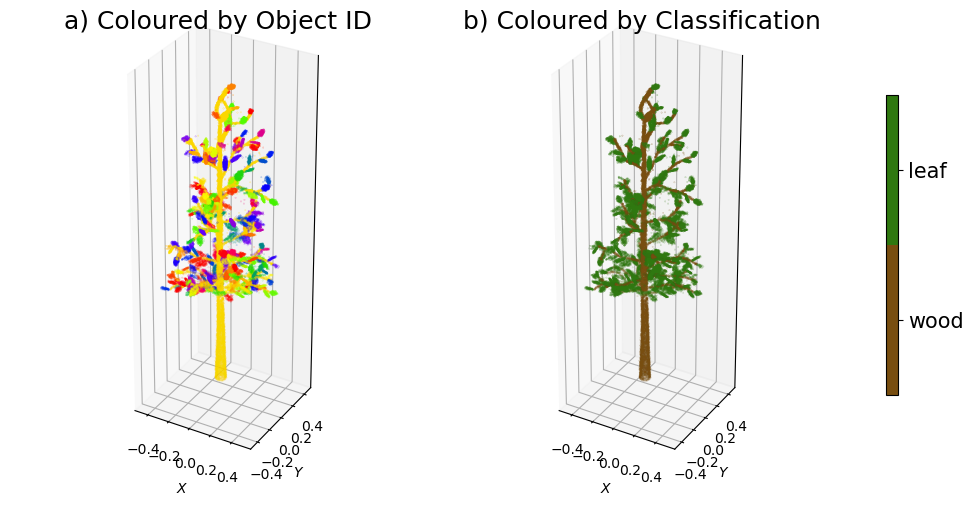

In [9]:
# Matplotlib figure
fig = plt.figure(figsize=(12, 6))

# First subplot
ax1 = fig.add_subplot(1,2,1, projection='3d', computed_zorder=False)
sc1 = ax1.scatter(pc[::10, 0],
                  pc[::10, 1],
                  pc[::10, 2],
                  c=object_id[::10], cmap='prism',
                  s=0.02, zorder=1)

ax1.set_xlabel('$X$')
ax1.set_ylabel('$Y$')
ax1.set_zticks([])
# set equal axes
box = (np.ptp(pc[:, 0]), np.ptp(pc[:, 1]), np.ptp(pc[:, 2]))
ax1.set_box_aspect(box)
ax1.set_title(label='a) Coloured by Object ID', fontsize=18)

# Second subplot
from matplotlib.colors import LinearSegmentedColormap
colours = ['#784e10', '#2f7810']
class_cmap = LinearSegmentedColormap.from_list('classification', colours, N=2)

ax2 = fig.add_subplot(1,2,2, projection='3d', computed_zorder=False)
sc2 = ax2.scatter(pc[::10, 0],
                  pc[::10, 1],
                  pc[::10, 2],
                  c=classification[::10], cmap=class_cmap,
                  s=0.02, zorder=1)

ax2.set_xlabel('$X$')
ax2.set_ylabel('$Y$')
ax2.set_zticks([])
ax2.set_box_aspect(box)
ax2.set_title(label='b) Coloured by Classification', fontsize=18)

# Adjust subplots
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
# Add color bar and set ticks and tick labels
cb_ax = fig.add_axes([0.83, 0.25, 0.01, 0.5])
tick_locs = [0.25, 0.75]
cbar = fig.colorbar(sc2, cax=cb_ax, ticks=tick_locs)
cbar.ax.set_yticklabels(['wood', 'leaf'], fontsize=15)

# Display results
plt.show()

Let's have a look at a few of the leaves, some of which are static and some of which are moving.

In [10]:
def clip_by_bb(pts, xmin, xmax, ymin, ymax, zmin, zmax):
    clip_index = ((pts[:, 0] > xmin) &
                  (pts[:, 0] < xmax) &
                  (pts[:, 1] > ymin) &
                  (pts[:, 1] < ymax) &
                  (pts[:, 2] > zmin) &
                  (pts[:, 2] < zmax))
    return clip_index

clip_idx = clip_by_bb(pc, -0.21, 0.116, -0.317, 0.02, 1.66, 1.88)
pc_clipped = pc[clip_idx]
pt_src_id_clipped = pt_src_id[clip_idx]
object_id_clipped = object_id[clip_idx]

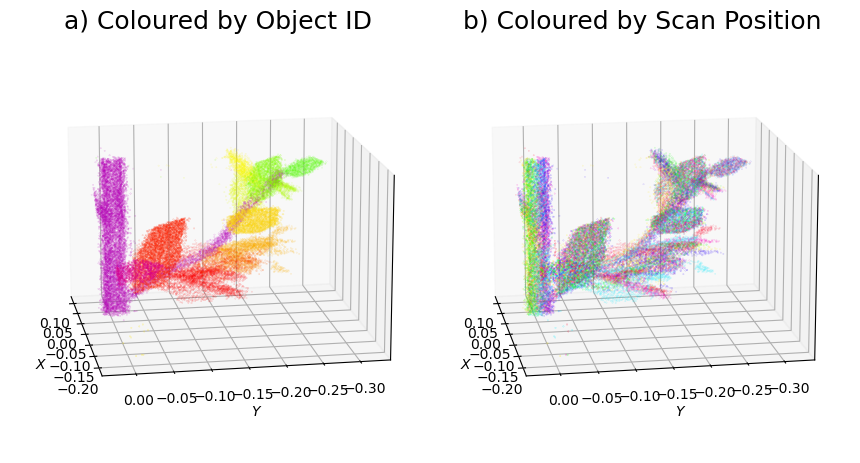

In [11]:
# Matplotlib figure
fig = plt.figure(figsize=(12, 6))

# First subplot
ax1 = fig.add_subplot(1,2,1, projection='3d', computed_zorder=False)
sc1 = ax1.scatter(pc_clipped[:, 0],
                  pc_clipped[:, 1],
                  pc_clipped[:, 2],
                  c=object_id_clipped, cmap='prism',
                  s=0.02, zorder=1)

ax1.set_xlabel('$X$')
ax1.set_ylabel('$Y$')
ax1.set_zticks([])
# set equal axes
box = (np.ptp(pc_clipped[:, 0]), np.ptp(pc_clipped[:, 1]), np.ptp(pc_clipped[:, 2]))
ax1.set_box_aspect(box)
ax1.view_init(elev=15, azim=170)
ax1.set_title(label='a) Coloured by Object ID', fontsize=18)

# Second subplot

ax2 = fig.add_subplot(1,2,2, projection='3d', computed_zorder=False)
sc2 = ax2.scatter(pc_clipped[:, 0],
                  pc_clipped[:, 1],
                  pc_clipped[:, 2],
                  c=pt_src_id_clipped, cmap='gist_rainbow',
                  s=0.02, zorder=1)

ax2.set_xlabel('$X$')
ax2.set_ylabel('$Y$')
ax2.set_zticks([])
ax2.set_box_aspect(box)
ax2.set_title(label='b) Coloured by Scan Position', fontsize=18)
ax2.view_init(elev=15, azim=170)
# Adjust subplots
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Display results
plt.show()

In [12]:
moving_leaves = [35, 57, 63, 73, 89, 124, 125, 130]
static_leaves = [167, 189, 195, 200, 220, 242, 251, 260]

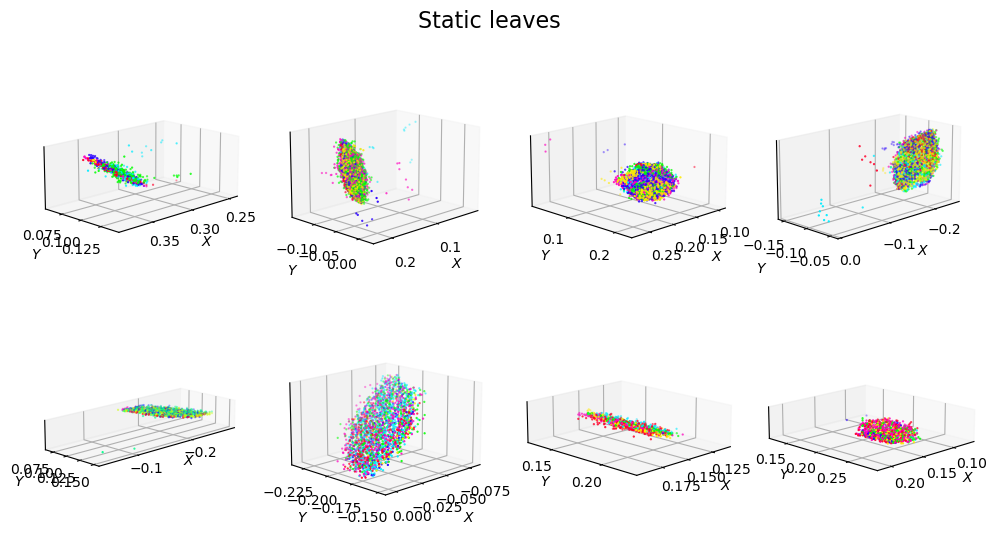

In [13]:
fig = plt.figure(figsize=(12, 6))

for i, leaf_id in enumerate(static_leaves):
    sel_idx = object_id == leaf_id
    pc_sel = pc[sel_idx]
    pt_src_id_sel = pt_src_id[sel_idx]

    ax = fig.add_subplot(2,4,i+1, projection='3d', computed_zorder=False)
    sc = ax.scatter(pc_sel[:, 0],
                     pc_sel[:, 1],
                     pc_sel[:, 2],
                     c=pt_src_id_sel, cmap='gist_rainbow',
                     s=0.4, zorder=1)

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zticks([])
    ax.view_init(elev=15, azim=45)
    # set equal axes
    box = (np.ptp(pc_sel[:, 0]), np.ptp(pc_sel[:, 1]), np.ptp(pc_sel[:, 2]))
    ax.set_box_aspect(box)
fig.suptitle('Static leaves', fontsize=16)
plt.show()

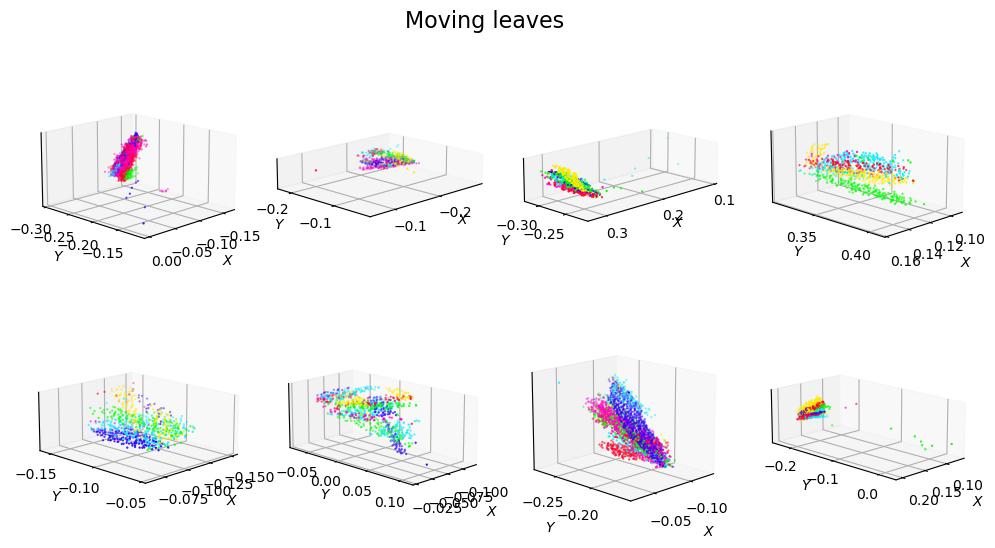

In [14]:
fig = plt.figure(figsize=(12, 6))

for i, leaf_id in enumerate(moving_leaves):
    sel_idx = object_id == leaf_id
    pc_sel = pc[sel_idx]
    pt_src_id_sel = pt_src_id[sel_idx]

    ax = fig.add_subplot(2,4,i+1, projection='3d', computed_zorder=False)
    sc = ax.scatter(pc_sel[:, 0],
                    pc_sel[:, 1],
                    pc_sel[:, 2],
                     c=pt_src_id_sel, cmap='gist_rainbow',
                     s=0.4, zorder=1)

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zticks([])
    ax.view_init(elev=15, azim=45)
    # set equal axes
    box = (np.ptp(pc_sel[:, 0]), np.ptp(pc_sel[:, 1]), np.ptp(pc_sel[:, 2]))
    ax.set_box_aspect(box)
fig.suptitle('Moving leaves', fontsize=16)
plt.show()